## Домашнее задание

### Задача: обучаем автоэнкодер на датасете MNIST
1.   Загрузить датасет MNIST (изображение рукописных цифр)
2.   Построить с помощью библиотеки Torch модель автоэнкодера
3.   Обучить сеть
4.   Сравнить значения функции потерь и метрик качества на train и test
5.   Написать краткий вывод с идеями по улучшению модели и процесса обучения

🖐 по заданию по нейронкам, вчера обсуждали

изначально нужен именно энкодер, с нейросетью которая из изображения на выходе дает то же изображение. Как метрику можно использовать попиксельный MSE

Также нужен по заданию классификатор скрытого состояния, то есть еще одна нейронка. На вход ей должен поступать выход латент слоя в энкодере, на выходе - написанное число

Но. Проблема со звуком на лекции скорее всего останется, так что для задания подойдет любая обученная модель нейронки, как просто классификатор, отличный от архитектуры нейросетей показанных на лекции, то есть с другим числом слоев, нейронов, оптимизаторов и тд

## Импорты

In [ ]:
import numpy as np
import torch
import torch.nn as nn   # слои нейронных сетей
import torch.optim as optim   # оптимизаторы
import matplotlib.pyplot as plt
# from sklearn.datasets import make_blobs, make_circles   # синтетические датасеты


import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F  # для подключения функции активации relu
from torchsummary import summary
# from torchmetrics import Accuracy

# Tqdm — это библиотека Python, которая предоставляет быстрые и расширяемые индикаторы выполнения для циклов и итераций. Это простой способ отслеживать выполнение трудоемких задач.
from tqdm import tqdm
# для определения метрик качества
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score


### Версия Torch, константы, вспомогательные функции

In [ ]:
# версия torch
# хорошая практика - фиксировать в ноутбуке версию torch и cuda
print(f'Версия torch. {torch.__version__=}')

Версия torch. torch.__version__='2.4.1+cu121'


In [ ]:
# Размер пакета (размер пачки данных, которые будут грузиться в модель за один раз)
batch_size = 64

In [ ]:
# определение device для torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps' for Mac
device

device(type='cpu')

In [ ]:
# Функция вычисления метрик
def get_metrics(model, y_pred, y_test) -> dict:
  # Метрики вычисляются из Confusion Matrix (матрицы ошибок)

  # Accuracy (точность). Количество сделанных правильных прогнозов (TP и TN), разделенное на общее количество сделанных прогнозов.
  # Accuracy = (TP + TN) / (TP + TN + FP + FN)

  # Recall (). Recall = TP / (TP + FN). Показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

  # Precision (прецизионность). Precision = TP / (TP + FP), где TP — количество истинных срабатываний, а FP — количество ложных срабатываний.

  # ROC-AUC + график
  # Он сообщает, какова вероятность того, что случайно выбранный положительный экземпляр будет иметь более высокий рейтинг, чем случайно выбранный отрицательный экземпляр.

  return({
      'model': model.__str__(),
      'accuracy_score' : round(accuracy_score(y_pred, y_test), 3),
      'recall_score' : round(recall_score(y_pred, y_test, average='weighted'), 3),
      'precision_score' : round(precision_score(y_pred, y_test, average='weighted'), 3)
  })

## Термины и общее понимание nn

In [ ]:
# Datasets.

# Датасет — это набор данных для машинного обучения. Обычно наборы бывают двух видов: для обучения и для проверки, как работает обученная модель.
# В большинстве ML-фреймворков, в том числе PyTorch, есть встроенные датасеты. Это наборы популярных и известных в сообществе пакетов данных.
# Для решения серьезных задач такие датасеты вряд ли подойдут, но они бывают нужны для прототипирования или при сравнительном анализе моделей.
# Быстрее и удобнее загрузить в сравниваемые модели тестовые датасеты и посмотреть на результаты, чем составлять и загружать реальные. К тому же реальные наборы данных зачастую больше весят, дольше обрабатываются и сильнее нагружают мощности.
# Должны быть реализованы:
# __init__
# __len__ - возвращает количество элементов в датасете
# __getitem__ - возвращает features и labels

In [ ]:
# Data Loader.

# Data Loader — это модуль, который позволяет создавать мини-пакеты в рамках одного датасета и подгружать их в модель.
# С его помощью можно перемешивать данные, определять размер мини-пакета и выполнять другие действия.

In [ ]:
# Функция активации

# Функция активации (activation function) — нелинейное преобразование, поэлементно применяющееся к пришедшим на вход данным.
# Благодаря функциям активации нейронные сети способны порождать более информативные признаковые описания, преобразуя данные нелинейным образом.
# Функция активации определяет выходное значение нейрона в зависимости от результата взвешенной суммы входов и порогового значения.
# Функция активации применяется к выходу из слоя nn. Должна быть нелинейной и дифференцируемой (Sigmoid, tahn, ReLU, Leaky ReLU, Maxout, ELU, SoftMax и др.)

In [ ]:
# Обучение нейронной сети.

# Процесс обучения:

# 1. Прямой проход: Вычислияем результат модели на обучающем датасете.
# 2. Вычисление потерь: Сравниваем прогнозы с реальными значениями и вычислияем функцию потерь.
# 3. Обратное распространение: Вычислияем градиенты по параметрам модели и обновияем веса сети.
# 4. Повторяем для каждой эпохи.

In [ ]:
# Оптимизатор.

# Оптимизатор — это алгоритм, используемый для минимизации функции потерь относительно обучаемых параметров модели. Наиболее простой метод оптимизации — градиентный спуск, который итеративно обновляет параметры модели, делая шаг в направлении самого крутого спуска ее функции потерь.
# Оптимизаторы определяют оптимальный набор параметров модели, таких как вес и смещение, чтобы при решении конкретной задачи модель выдавала наилучшие результаты.
# Самой распространённой техникой оптимизации, используемой большинством нейронных сетей, является алгоритм градиентного спуска
# Реализует стохастический градиентный спуск (необязательно с импульсом). Импульс Нестерова основан на формуле "О важности инициализации и импульса в глубоком обучении"
# torch.optim.SGD: стохастический градиентный спуск,
# torch.optim.Adam: адаптивная оценка моментов,
# torch.optim.RMSprop:алгоритм, разработанный Джеффри Хинтоном в рамках его курса для Coursera,
# torch.optim.LBFGS: алгоритм Бройдена-Флетчера-Гольдфарба-Шанно с ограниченным использованием памяти

In [ ]:
# Функция потерь.

# Функция потерь находится в центре нейронной сети. Она используется для расчета ошибки между реальными и полученными ответами. Цель работы nn — минимизировать эту ошибку.
# Создает критерий, который измеряет среднеквадратичную ошибку (квадрат нормы L2) между каждым элементом на входе x и целевым y . nn.CrossEntropyLoss.
# Этот критерий вычисляет перекрестную потерю энтропии между входными логитами и целевым значением.
# torch.nn также предоставляет ряд функций потерь, естественно, важных для приложений в сфере машинного обучения. Примеры таких функций:
# torch.nn.MSELoss: средняя квадратичная функция потерь
# torch.nn.BCELoss: функция потерь бинарной кросс-энтропии,
# torch.nn.KLDivLoss: функция потерь информационного расхождения Кульбака-Лейблера

In [ ]:
# Архитектура nn (пример). Этот код определяет простую нейронную сеть с двумя полносвязными слоями.
# import torch.nn as nn

# class SimpleNN(nn.Module):
#     def __init__(self):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(784, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [ ]:
# Обучение - это процесс, в котором сеть корректирует свои веса для минимизации ошибки предсказания. Вот базовый цикл обучения:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         optimizer.zero_grad()
#         outputs = model(batch)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()

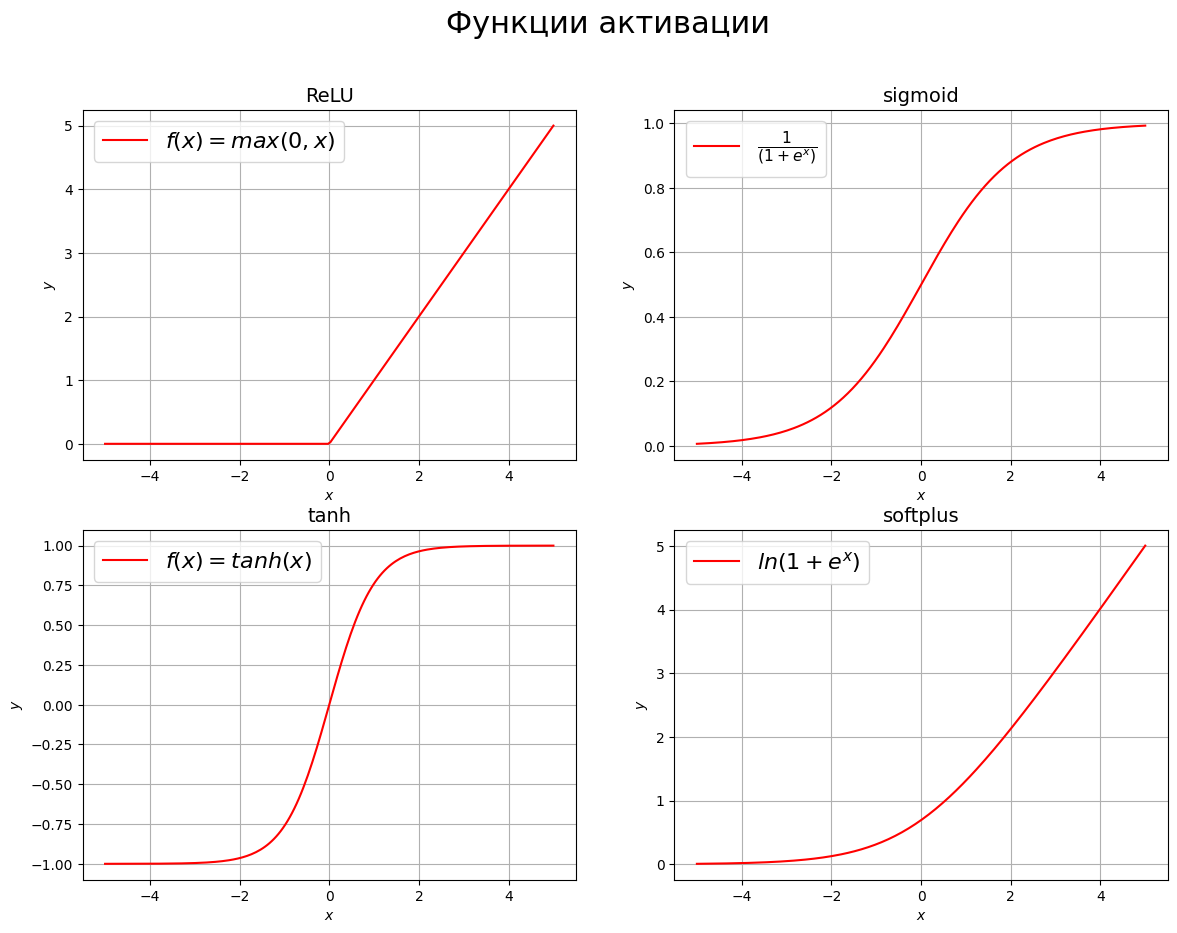

In [ ]:
import torch
import torch.nn.functional as F # Импортировать функциональный модуль активации
from torch.autograd import Variable
import matplotlib.pyplot as plt # для построения графика


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

t = zip(
    axs.flatten(),
    [torch.relu, torch.sigmoid, torch.tanh, F.softplus],
    ["ReLU", "sigmoid", "tanh", "softplus"],
    ["$f(x) = max(0, x)$", "$\\frac{1}{(1 + e^x)}$", "$f(x) = tanh(x)$", "$ln(1 + e^x)$"]
)

plt.suptitle("Функции активации", fontsize=22)
x = torch.linspace (-5, 5, 200)
for i, (ax, activation_funcion, activation_function_name, label) in enumerate(t):
    y = activation_funcion(x)
    ax.plot(x, y, c='red', label=label)
    ax.legend(prop={'size': 16})
    ax.set_title(activation_function_name, fontsize=14)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.grid()

## Загрузка датасета MINST (изображение рукописных цифр)

In [ ]:
# Data Normalization
# Загрузка и нормализация данных. transforms.Compose формирует конвейер преобразования, через который проходят ВСЕ изображения при входе в модель для обучения.
# В torchvision.transforms.Normalize на вход передаются среднее и отклонение для каждого канала. Среднее: torch.mean(), отклонение: torch.std().
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.0], [1.])])
transform

Compose(
    ToTensor()
    Normalize(mean=[0.0], std=[1.0])
)

In [ ]:
# MNIST dataset

# Тренировочный датасет
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transform,
                                           download=True)

# Тестовый датасет
test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 9537909.93it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1964224.58it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 8670398.57it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4379431.90it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.0], std=[1.0])
           )

In [ ]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.0], std=[1.0])
           )

In [ ]:
# Data loader. Загрузчик. Класс, который работает с датасетом и помогает грузить по batch.

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

In [ ]:
train_dataloader

In [ ]:
test_dataloader

In [ ]:
next(iter(train_dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [ ]:
# item (элемент) - tensor, target (метка) - tensor - таргет
item, target = next(iter(train_dataloader))
# my_list = list(train_dataloader)

In [ ]:
# количество пикселов в картинках
# num_pixels = len(item[0][0][0]) * len(item[0][0][0])
num_pixels = item[0][0][0].numel() * item[0][0][0].numel()
num_pixels

784

In [ ]:
# количество таргетов (т.е. цифр)
# unique() возвращает тензор уникальных значений
num_targets = target.unique().numel()
num_targets

10

In [ ]:
item
# item, label = my_list[1]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [ ]:
target

tensor([6, 1, 0, 5, 8, 6, 7, 2, 6, 6, 5, 3, 0, 5, 5, 4, 8, 6, 5, 5, 3, 6, 1, 8,
        9, 2, 1, 0, 6, 5, 3, 3, 3, 2, 6, 9, 4, 4, 0, 3, 6, 3, 9, 0, 2, 3, 9, 1,
        4, 5, 3, 7, 5, 6, 8, 5, 7, 7, 8, 3, 9, 7, 1, 1])

In [ ]:
item.shape

torch.Size([64, 1, 28, 28])

Учитель. target[index].item()=6


Text(0.5, 1.0, 'tensor(6)')

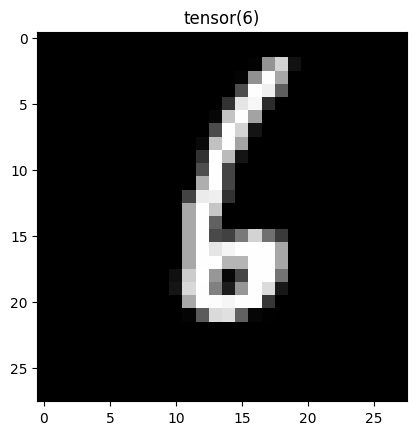

In [ ]:
# Посмотрим, что загрузилось
index = 0
print(f'Учитель. {target[index].item()=}')
picture = item[index, 0]

# fig, ax = plt.subplots(nrows=1, ncols=2)
plt.imshow(picture, cmap='gray')
plt.title(target[index])

## Модели

### Модель автоэнкодера

In [ ]:
# Автоэнкодер
# Autoencoder (автокодер, автоэнкодер, AE) — нейронная сеть, которая копирует входные данные на выход. По архитектуре похож на персептрон.
# Автоэнкодеры сжимают входные данные для представления их в latent-space (скрытое пространство), а затем восстанавливают из этого представления output (выходные данные).
# Цель — получить на выходном слое отклик, наиболее близкий к входному.

# Не готова

# Наследуемся от nn.Module
class AutoEncoderModel(nn.Module):
    def __init__(self):
        # чтобы все атрибуты и методы родительского класса были доступны в классе-потомке
        super().__init__()

        # ОПИСАТЬ СЛОИ и ФУНКЦИИ АКТИВАЦИИ

    # переопределяем метод forward, который задаёт граф вычислений (порядок применения слоёв и функций активации)
    def forward(self, x):
      pass
        # ОПИСАТЬ метод. Пока заглушка.



### Модель классификатора

In [ ]:
# Наследуемся от nn.Module
class ClassifierModel(nn.Module):
    def __init__(self, in_features, out_features):
        # чтобы все атрибуты и методы родительского класса были доступны в классе-потомке
        super().__init__()

        self.in_features = in_features
        # количество нейронов скрытого слоя уменьшаем / увеличиваем в coeff раз, соблюдая квадратную размерность картинки
        coeff = 3
        # self.hidden_units = (int(in_features ** 0.5) // coeff) ** 2
        # увеличение нейронов скрытого слоя улучшает метрики модели, требует меньше эпох для обучения, но задействует больше вычислительных ресурсов
        self.hidden_units = in_features * coeff

        print(f'{self.hidden_units}')
        self.out_features = out_features

        # Можно прописывать через torch.nn.Sequential (Последовательный контейнер). Модули будут добавляться в него в том порядке, в котором они переданы в конструкторе.
        # Пример:
        # self.linear_layer_stack = torch.nn.Sequential(
        #     torch.nn.Linear(in_features=input_features, out_features=hidden_units),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features=hidden_units, out_features=output_features),
        # )

        # Пока пишем подробно:

        # Входной слой содержит in_features нейронов
        # nn. Linear(n,m) — это модуль, который создает однослойную сеть прямого распространения с n входами и m выходами.
        #  Математически этот модуль предназначен для вычисления линейного уравнения Ax = b, где x — вход, b — выход, A — вес.
        self.layer_1 = nn.Linear(in_features=self.in_features, out_features=self.hidden_units)

        # Скрытый слой содержит hidden_features нейронов
        self.layer_2 = nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units)

        # Выходной слой содержит out_features нейронов
        self.layer_3 = nn.Linear(in_features=self.hidden_units, out_features=self.out_features)

        # Функция активации.
        # Sigmoid - наиболее часто используемая
        self.activation_function = nn.Sigmoid()
        # ReLU - наименее вычислительно затратная
        # self.activation_function = F.relu()

    # переопределяем метод forward, который задаёт граф вычислений (порядок применения слоёв и функций активации)
    def forward(self, x):

      # Если слои и функции активации заданы в контейнере:
      # return self.linear_layer_stack(x)

      # в вектор (одномерный тензор)
      # Изменение формы
      # Форма тензора (число индексов и их размерности) меняется функциями view и reshape:
      # torch.arange(6).view(2,3)         #    tensor([[0, 1, 2],
      # torch.arange(6).reshape(2,3)      #            [3, 4, 5]])
      # В этих функциях перечисляются новые размерности индексов (их произведение должно совпадать с числом элементов).
      # Одна из размерностей может быть равна -1 и тогда она будет посчитана автоматически. Например, выше можно было бы написать view(-1,3) или view(2,-1).
      # Функция .view() работает с переменными PyTorch и преобразует их форму.
      # Если мы точно не знаем размерность данного измерения, можно использовать ‘-1’ нотацию в определении размера.
      # Поэтому при использование data.view(-1,28*28) можно сказать, что второе измерение должно быть равно 28 x 28, а первое измерение должно быть вычислено из размера переменной оригинальных данных.
        x = x.view(-1, self.in_features)
        x = self.layer_1(x)
        # x = self.activation_function(x)
        # или, если используем фнкцию активации ReLU
        x = F.relu(x)
        # использование дополнительного скрытого слоя не привело к улучшению качества метрик. Почему?
        x = self.layer_2(x)
        # x = self.activation_function(x)
        # или, если используем фнкцию активации ReLU
        x = F.relu(x)
        x = self.layer_3(x)
        # return F.log_softmax(x)   # ЗАЧЕМ ?

        return x

## Обучение сети

In [ ]:
# Общий порядок создания и обучения сети. Он одинаковый.

# Подготовка
# 1. Задать модель - nn.Module
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM

# Поместить модель и метрику на DEVICE (CPU или GPU). Всё должно быть на одном устройстве.

# Создать вспомогательные списки для данных
# лосс для каждой итерации
# общий лосс
# accuracy
# задать общее количество эпох
# для каждой эпохи
  # для каждой части датасета (можно сделать метод fit в модели)
    # ЭТАП ОБУЧЕНИЯ
    # переводим модель в режим обучения
    # обнуляем градиенты у оптимизатора
    # пропускаем данные через модель
    # выравниваем выходы в одномерный тензор
    # считаем лосс
    # делаем шаг в обратном направлении
    # собираем лоссы
    # делаем шаг оптимизатора
  # собираем средний лосс (на эпоху)
  # ШАГ ВАЛИДАЦИИ (можно следать метод predict в модели)
    # режим интерфейса (валидации, тестирования)
    # обязательно добавить torch.no_grad():
      # считаем вероятности
      # считаем метрику

# После обучения очистить кэш
# with torch.no_grad():
    # torch.cuda.empty_cache()

In [ ]:
# ПОДГОТОВКА

# Количество эпох
num_epochs = 3

# Скорость обучения
# learning_rate = 0.01
learning_rate = 0.1
# learning_rate = 1

# Создаём модель
# in_features - количество пикселов, out_features - количество таргетов (цифр)
model = ClassifierModel(in_features=num_pixels, out_features=num_targets)

# Оптимизатор
# Оптимизатор                           	  Задача                          	  Код
# Стохастический градиентный спуск (SGD)	  Классификация, регрессия и другие	  torch.optim.SGD()
# Adam Optimizer	                          Классификация, регрессия и другие	  torch.optim.Adam()

# Функция потерь                        	  Задача                          	  Код
# Binary cross entropy loss	                Бинарная классификация	            torch.nn.BCELossWithLogits или torch.nn.BCELoss
# Cross entropy loss	                      Многоклассовая классификация	      torch.nn.CrossEntropyLoss
# Mean absolute error (MAE) или L1 Loss	    Регрессия	                          torch.nn.L1Loss
# Mean squared error (MSE) или L2 Loss	    Регрессия	                          torch.nn.MSELoss

optimizer = torch.optim.SGD(lr=learning_rate, params=model.parameters())
# optimizer = torch.optim.Adam(lr=learning_rate, params=model.parameters())

# Функция потерь
# для многоклассовой классификции используем Cross entropy loss
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.BCEWithLogitsLoss()

# ЗАЧЕМ ???
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000) # cos((1000 / 1000) * pi) * lr -> eta_min

# Чтобы получить суммарную информацию о модели в PyTorch, вы можете воспользоваться библиотекой torchinfo. Для её установки используйте команду pip install torchinfo. Получить сводку модели можно с помощью функции summary, передав в качестве параметров саму модель и размерность входного тензора:
# Библиотека torchinfo предоставляет информацию в обобщённом виде. Но если необходим более глубокий анализ модели, можно воспользоваться pytorch-summary.
# Это позволит получить информацию о числе параметров и использовании памяти, что необходимо при оптимизации её использования. Если вы работаете не на GPU, замените значение 'cuda' на 'cpu'.
summary(model.to(device), (1, 28, 28))

2352
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2352]       1,846,320
            Linear-2                 [-1, 2352]       5,534,256
            Linear-3                   [-1, 10]          23,530
Total params: 7,404,106
Trainable params: 7,404,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 28.24
Estimated Total Size (MB): 28.28
----------------------------------------------------------------


In [ ]:
# Обучение модели

# Передаём model на device
model.to(device)

# Перевод модели в режим обучения
model.train()

# список значений функции потерь для train
loss_list_train = []

total_step = len(train_dataloader)

# список учителей (train)
true_labels_list_train = []
# список прогнозов модели (train)
predicted_labels_list_train = []

# для каждой эпохи
for epoch in tqdm(range(1, num_epochs + 1)):
  # для каждой части датасета
    for i, (images, targets) in enumerate(train_dataloader):
        # Move tensors to the configured device
        # тензоры на device
        # входы
        images = images.to(device)
        # учителя
        targets = targets.to(device)

        true_labels_list_train.extend(targets.cpu().numpy())

        # ???
        targets = F.one_hot(targets, num_classes=num_targets).to(torch.float32)

        # Forward pass (прямой проход)
        outputs = model(images)
        # функция потерь для прохода
        loss = loss_function(outputs, targets)  # criterion

        outputs = F.sigmoid(outputs)  # model do not contain nn.Sigmoid
        predicted_labels = torch.argmax(outputs, dim=1)

        predicted_labels_list_train.extend(predicted_labels.cpu().numpy())

        # Backward and optimize
        # обнуляем градиенты у оптимизатора
        optimizer.zero_grad()
        # делаем шаг в обратном направлении
        loss.backward()
        # делаем шаг оптимизатора
        optimizer.step()

        # # loss_list.append(loss.detach().cpu().numpy())
        # loss_list.append(loss.detach().cpu().numpy().item())
        loss_list_train.append(loss.detach().cpu().numpy().item())

        fraction = 5
        # выводим для каждой fraction из тренировочного датасета
        if (i + 1) % (len(train_dataloader) // fraction) == 0:
            print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

    # scheduler.step()    # ЗАЧЕМ, если есть optimizer.step()

# После обучения очистить кэш
with torch.no_grad():
    torch.cuda.empty_cache()

print (f'\nFinish:\nEpoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

# метрики качества. считаем при помощи sklearn
train_metrics = get_metrics(model=model, y_pred=predicted_labels_list_train, y_test=true_labels_list_train)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/3], Step [187/938], Loss: 0.2657
Epoch [1/3], Step [374/938], Loss: 0.2179
Epoch [1/3], Step [561/938], Loss: 0.1714
Epoch [1/3], Step [748/938], Loss: 0.1216
Epoch [1/3], Step [935/938], Loss: 0.1372


 33%|███▎      | 1/3 [01:32<03:05, 92.51s/it]

Epoch [2/3], Step [187/938], Loss: 0.2573
Epoch [2/3], Step [374/938], Loss: 0.1216
Epoch [2/3], Step [561/938], Loss: 0.2385
Epoch [2/3], Step [748/938], Loss: 0.0535


 67%|██████▋   | 2/3 [02:55<01:26, 86.99s/it]

Epoch [2/3], Step [935/938], Loss: 0.1105
Epoch [3/3], Step [187/938], Loss: 0.0725
Epoch [3/3], Step [374/938], Loss: 0.0656
Epoch [3/3], Step [561/938], Loss: 0.0549
Epoch [3/3], Step [748/938], Loss: 0.1391


100%|██████████| 3/3 [04:13<00:00, 84.47s/it]

Epoch [3/3], Step [935/938], Loss: 0.0481



Finish:
Epoch [3/3], Step [938/938], Loss: 0.0634


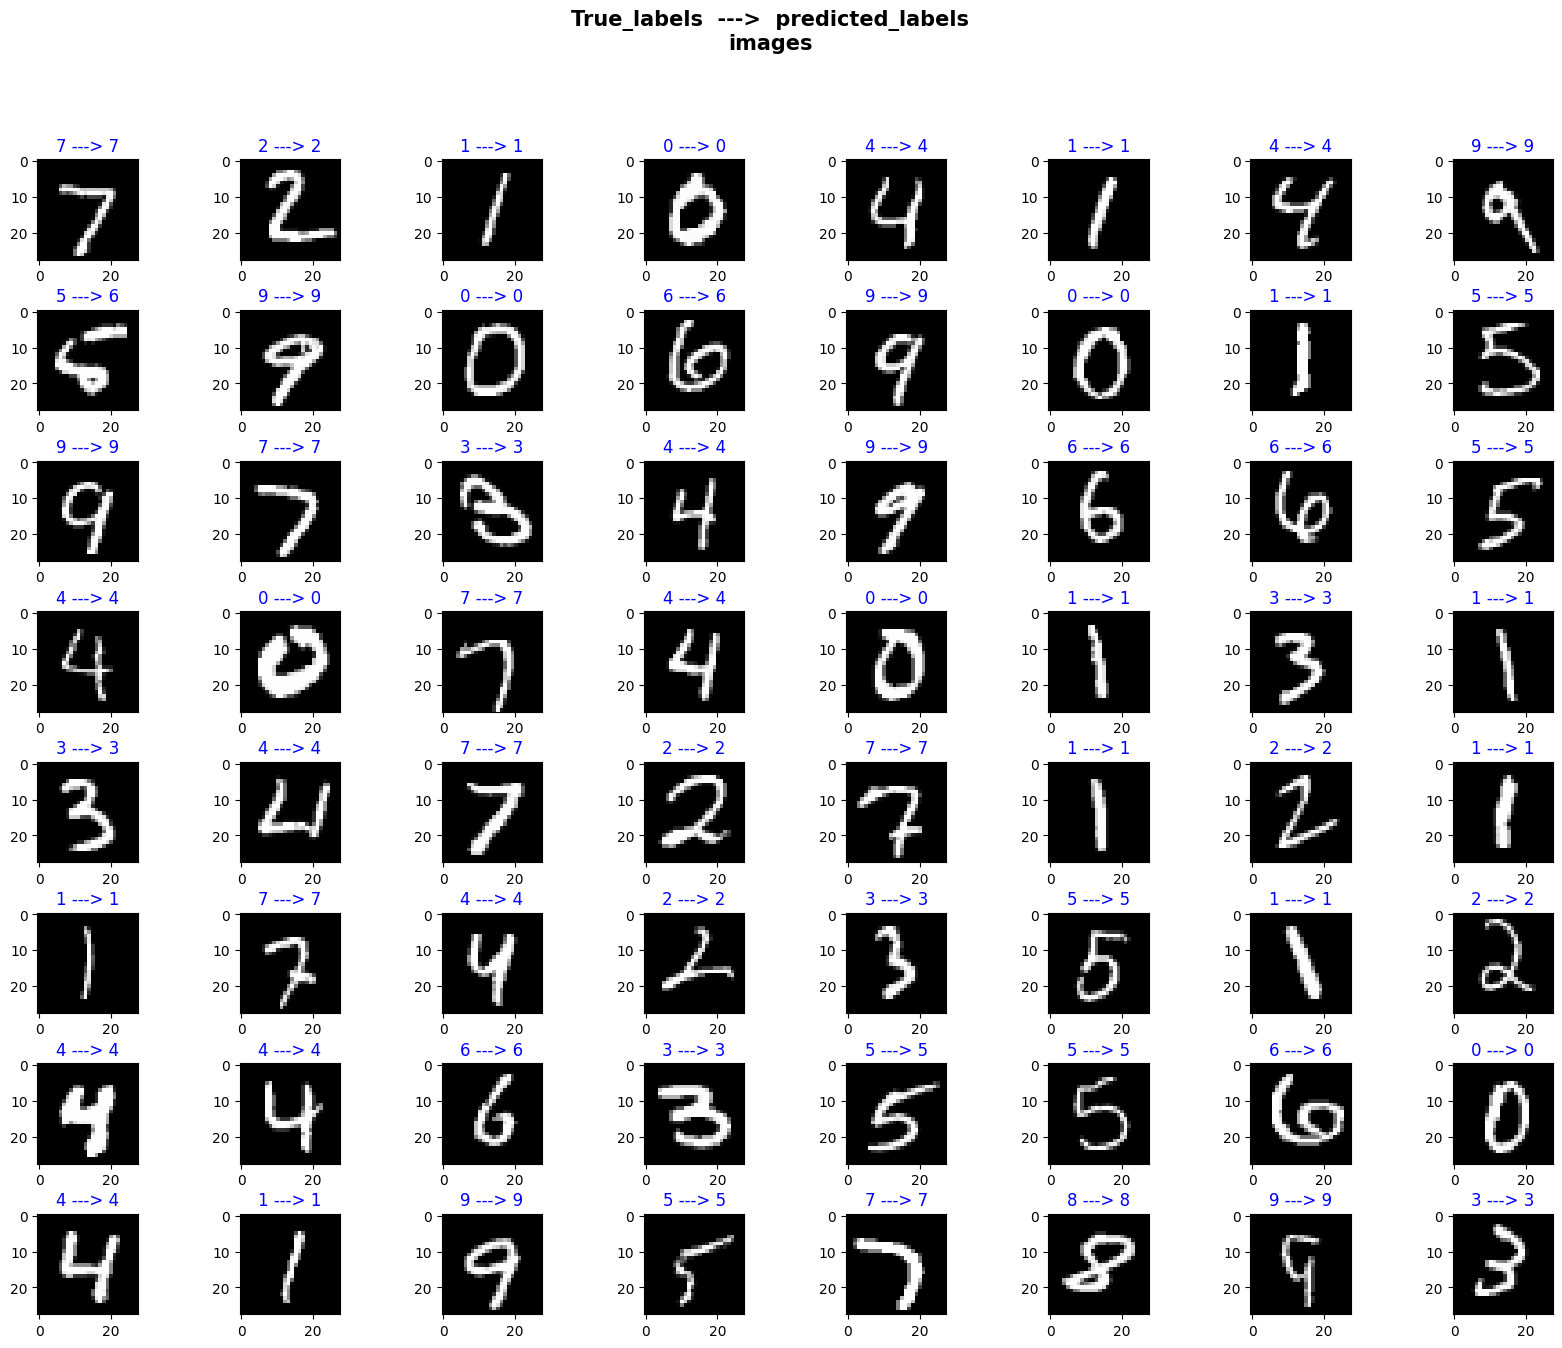

In [ ]:
# Тестирование модели

# список учителей
true_labels_list_test = []
# список прогнозов модели
predicted_labels_list_test = []

# список значений функции потерь для test
loss_list_test = []

# Перевод модели в режим вычисления
# Преводит модель PyTorch в режим оценки, отключая такие операции, как выпадение, полезные для вывода и тестирования.
model.eval()

show_batch = True

# цикл для каждой части (batch) тестового датасета
for images, labels in test_dataloader:

    images = images.to(device)
    labels = labels.to(device)

    # In test phase, we don't need to compute gradients (for memory efficiency)
    # В тестовом режиме нет необходимости вычислять градиенты
    with torch.no_grad():
        predict = model(images)

    true_labels_list_test.extend(labels.cpu().numpy())

    # ???
    labels = F.one_hot(labels, num_classes=num_targets).to(torch.float32)

    # функция потерь для прохода
    loss = loss_function(predict, labels)  # criterion
    loss_list_test.append(loss.detach().cpu().numpy().item())

    predict = F.sigmoid(predict)  # model do not contain nn.Sigmoid
    predicted_labels = torch.argmax(predict, dim=1)

    predicted_labels_list_test.extend(predicted_labels.cpu().numpy())

    # отрисуем первый batch
    if show_batch:
      # Посмотрим, что и как определилось (на примере последнего batch)
      plt.figure(figsize=[20, 15])
      # растояния между графиками
      plt.subplots_adjust(wspace=0.5, hspace=0.5)
      plt.suptitle('True_labels  --->  predicted_labels\nimages', fontsize=15, fontweight='bold')

      for idx in range(batch_size):
        picture = images[idx][0].cpu()

        plt.subplot(int(batch_size ** 0.5), int(batch_size ** 0.5), idx + 1)
        plt.imshow(picture, cmap='gray')
        plt.title(f'{true_labels_list_test[idx]} ---> {predicted_labels_list_test[idx]}', fontsize=12, color='blue')
      show_batch = False

# метрики качества. считаем при помощи sklearn
test_metrics = get_metrics(model=model, y_pred=predicted_labels_list_test, y_test=true_labels_list_test)
# но можно и напрямую через confusion matrix
# cm = confusion_matrix(true_labels_list, predicted_labels_list)


## Функция потерь и метрики качества:

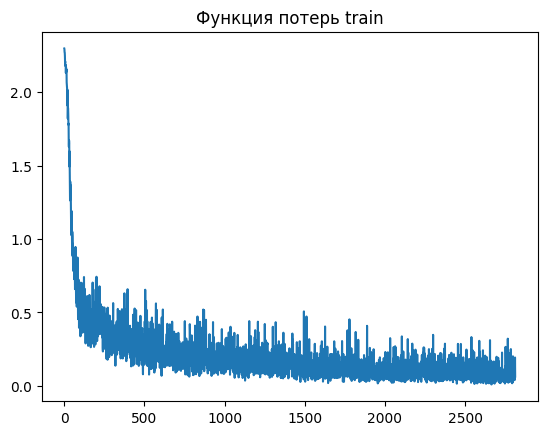

In [ ]:
plt.title('Функция потерь train')
plt.plot(loss_list_train)

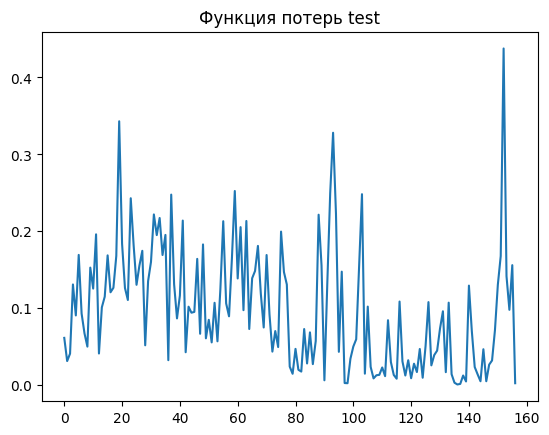

In [ ]:
plt.title('Функция потерь test')
plt.plot(loss_list_test)

In [ ]:
train_metrics

{'model': 'ClassifierModel(\n  (layer_1): Linear(in_features=784, out_features=2352, bias=True)\n  (layer_2): Linear(in_features=2352, out_features=2352, bias=True)\n  (layer_3): Linear(in_features=2352, out_features=10, bias=True)\n  (activation_function): Sigmoid()\n)',
 'accuracy_score': 0.938,
 'recall_score': 0.938,
 'precision_score': 0.939}

In [ ]:
test_metrics

{'model': 'ClassifierModel(\n  (layer_1): Linear(in_features=784, out_features=2352, bias=True)\n  (layer_2): Linear(in_features=2352, out_features=2352, bias=True)\n  (layer_3): Linear(in_features=2352, out_features=10, bias=True)\n  (activation_function): Sigmoid()\n)',
 'accuracy_score': 0.969,
 'recall_score': 0.969,
 'precision_score': 0.97}

## Выводы и идеи

In [ ]:
# 0. Использование GPU вместо CPU очень сильно ускоряет процесс обучения модели. Правда в Google Colab не всегда получается сменить среду выполнения.
# 1. Функция потерь Cross entropy loss даёт лучшие результаты, чем Binary cross entropy loss.
# 2. Обучения модели с использованием оптимайзера SGD происходим быстрее, чем с оптимайзером Adam. Но разброс метрик между train и test уменьшается.
# 3. Увеличение количества нейронов в скрытом слое модели уменьшает количество эпох в обучении для достижения приемлемого качества.
# 4. Увеличение количества эпох больше трёх не особо влияет на метрики качества модели.
# 5. Использование функции активации ReLU показало лучшие метрики качества по сравнению с Sigmoid.
# 6. Использование дополнительного скрытого слоя в модели привело к улучшению метрик качества (с функцией ReLU) и к увеличению времени обучения модели.
# 7. learning_rate можно увеличить до 0.1 без ухудшения качества обучения, но с уменьшением времени обучения модели.

# В ноутбуке сохранен лучший (как мне показалось) подбор параметров для обучения и тестирования модели, при котором метрики качества максимальные.